__mlmachine - Part 6: Basic Model Evaluation__

1. [Binary Classification Model Performance](#Binary-Classification-Model-Performance)
1. [Regression Model Performance](#Regression-Model-Performance)

In [7]:
# standard libary and settings
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    KBinsDiscretizer,
    RobustScaler,
    PolynomialFeatures,
)
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from category_encoders import WOEEncoder, TargetEncoder, CatBoostEncoder
from hyperopt import hp
from xgboost import XGBClassifier
import mlmachine as mlm
from mlmachine.data import titanic
from mlmachine.features.preprocessing import (
    DataFrameSelector,
    PandasTransformer,
    PandasFeatureUnion,
    GroupbyImputer,
    KFoldEncoder,
    DualTransformer,
)

# Binary Classification Model Performance

<a id = 'Binary-Classification-Model-Performance'></a>

# Regression Model Performance

<a id = 'Regression-Model-Performance'></a>

In [8]:
import mlmachine as mlm
from mlmachine.data import titanic

df_train, df_valid = titanic()

ordinal_encodings = {"Pclass": [1, 2, 3]}

mlmachine_titanic_train = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId","Ticket","Name","Cabin"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings=ordinal_encodings,
    is_classification=True,
)

mlmachine_titanic_valid = mlm.Machine(
    data=df_valid,
    remove_features=["PassengerId","Ticket","Name","Cabin"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings=ordinal_encodings,
    is_classification=True,
)

### impute pipeline
impute_pipe = PandasFeatureUnion([
    ("age", make_pipeline(
        DataFrameSelector(include_columns=["Age","SibSp"]),
        GroupbyImputer(null_column="Age", groupby_column="SibSp", strategy="mean")
    )),
    ("fare", make_pipeline(
        DataFrameSelector(include_columns=["Fare","Pclass"]),
        GroupbyImputer(null_column="Fare", groupby_column="Pclass", strategy="mean")
    )),
    ("embarked", make_pipeline(
        DataFrameSelector(include_columns=["Embarked"]),
        PandasTransformer(SimpleImputer(strategy="most_frequent"))
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=["Age","Fare","Embarked"])
    )),
])

mlmachine_titanic_machine.training_features = impute_pipe.fit_transform(mlmachine_titanic_machine.training_features)
mlmachine_titanic_machine.validation_features = impute_pipe.transform(mlmachine_titanic_machine.validation_features)

# transform pipe
polynomial_pipe = PandasFeatureUnion([
    ("polynomial", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        PandasTransformer(PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"]),
    )),
])

mlmachine_titanic_machine.training_features = polynomial_pipe.fit_transform(mlmachine_titanic_machine.training_features)
mlmachine_titanic_machine.validation_features = polynomial_pipe.transform(mlmachine_titanic_machine.validation_features)

mlmachine_titanic_machine.update_dtypes()
mlmachine_titanic_

### encode & bin pipeline
encode_pipe = PandasFeatureUnion([
    ("nominal", make_pipeline(
        DataFrameSelector(include_columns=mlmachine_titanic_machine.training_features.mlm_dtypes["nominal"]),
        PandasTransformer(OneHotEncoder(drop="first")),
    )),
    ("ordinal", make_pipeline(
        DataFrameSelector(include_columns=list(ordinal_encodings.keys())),
        PandasTransformer(OrdinalEncoder(categories=list(ordinal_encodings.values()))),
    )),
    ("bin", make_pipeline(
        DataFrameSelector(include_columns=mlmachine_titanic_machine.training_features.mlm_dtypes["continuous"]),
        PandasTransformer(KBinsDiscretizer(encode="ordinal")),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=mlmachine_titanic_machine.training_features.mlm_dtypes["nominal"] + list(ordinal_encodings.keys())),
    )),
])

mlmachine_titanic_machine.training_features = encode_pipe.fit_transform(mlmachine_titanic_machine.training_features)
mlmachine_titanic_machine.validation_features = encode_pipe.fit_transform(mlmachine_titanic_machine.validation_features)

mlmachine_titanic_machine.update_dtypes()
mlmachine_titanic_

### impute pipeline
target_encode_pipe = PandasFeatureUnion([
    ("target", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]), 
        KFoldEncoder(
            target=mlmachine_titanic_machine.training_target,
            cv=KFold(n_splits=5, shuffle=True, random_state=0),
            encoder=TargetEncoder,
        ),
    )),
    ("woe", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldEncoder(
            target=mlmachine_titanic_machine.training_target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=WOEEncoder,
        ),
    )),
    ("catboost", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldEncoder(
            target=mlmachine_titanic_machine.training_target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=CatBoostEncoder,
        ),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["category"]),
    )),
])

mlmachine_titanic_machine.training_features = target_encode_pipe.fit_transform(mlmachine_titanic_machine.training_features)
mlmachine_titanic_machine.validation_features = target_encode_pipe.transform(mlmachine_titanic_machine.validation_features)

mlmachine_titanic_machine.update_dtypes()
mlmachine_titanic_

### scale values
scale = PandasTransformer(RobustScaler())

mlmachine_titanic_machine.training_features = scale.fit_transform(mlmachine_titanic_machine.training_features)
mlmachine_titanic_machine.validation_features = scale.transform(mlmachine_titanic_machine.validation_features)

>>> category label encoding

	0 --> 0
	1 --> 1



Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


In [9]:
bayes_optim_summary = pd.read_csv("bayes_optimization_summary_accuracy.csv", na_values="nan")

# classification panel, single model
estimator = 'RandomForestClassifier'; model_iter = 46

# reinstantiate model
model = mlmachine_titanic_machine.BayesOptimClassifierBuilder(
    bayes_optim_summary=bayes_optim_summary,
    estimator_class=estimator,
    model_iter=model_iter,
)

*******************************************************
* Estimator: RandomForestClassifier
* Parameter set: 46
*******************************************************

*******************************************************
Training data evaluation

              precision    recall  f1-score   support

        Dies       0.93      0.98      0.95       549
    Survives       0.96      0.89      0.92       342

    accuracy                           0.94       891
   macro avg       0.95      0.93      0.94       891
weighted avg       0.94      0.94      0.94       891



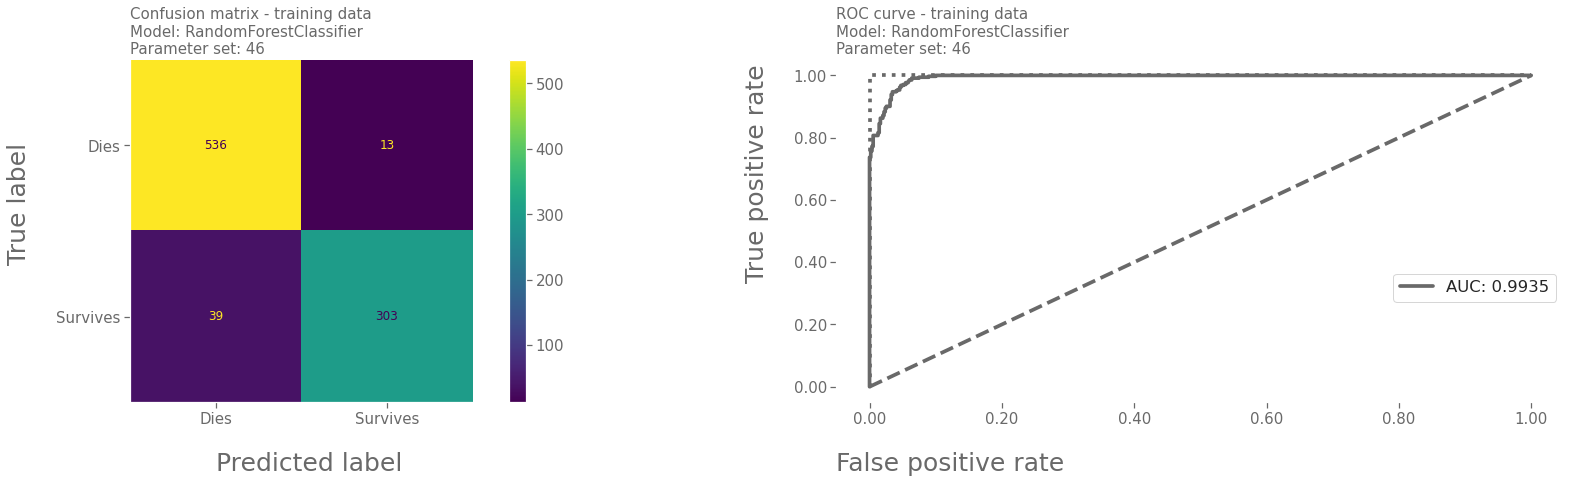

In [10]:
# create binary classification panel
mlmachine_titanic_machine.binary_classification_panel(
    model=model,
    X_train=mlmachine_titanic_machine.training_features,
    y_train=mlmachine_titanic_machine.training_target,
    labels=["Dies", "Survives"],
)

*******************************************************
* Estimator: RandomForestClassifier
* Parameter set: 46
*******************************************************

*******************************************************
Training data evaluation

              precision    recall  f1-score   support

        Dies       0.95      0.98      0.96       412
    Survives       0.96      0.91      0.93       256

    accuracy                           0.95       668
   macro avg       0.95      0.94      0.95       668
weighted avg       0.95      0.95      0.95       668



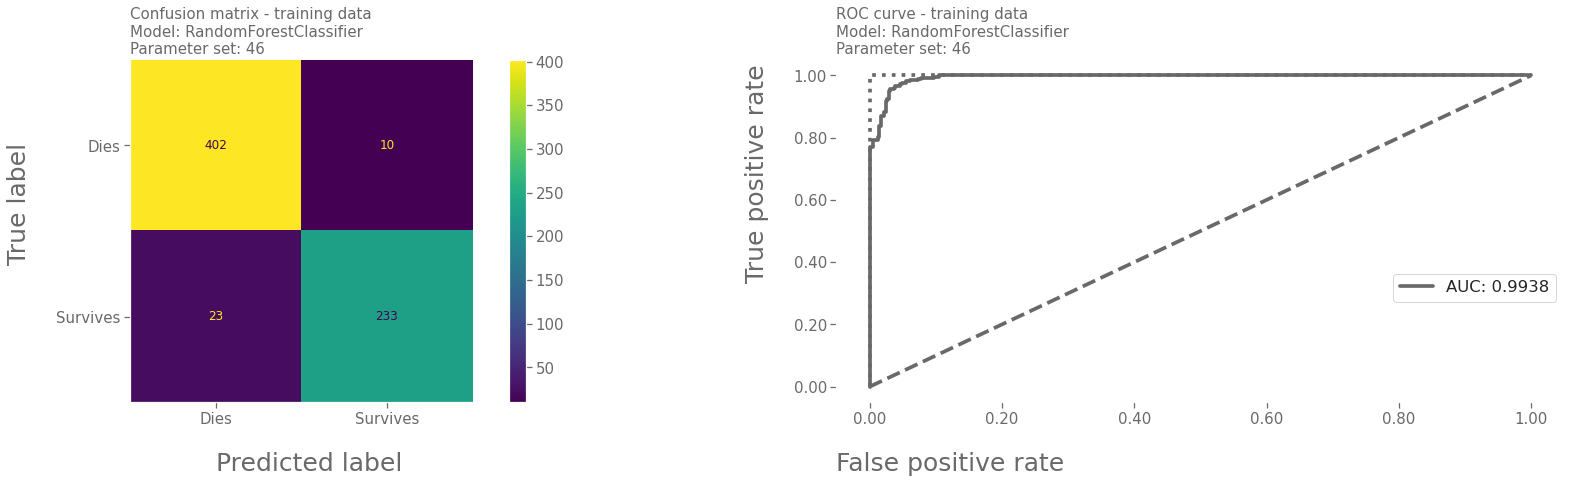


*******************************************************
Validation data evaluation

              precision    recall  f1-score   support

        Dies       0.82      0.91      0.87       137
    Survives       0.83      0.69      0.75        86

    accuracy                           0.83       223
   macro avg       0.83      0.80      0.81       223
weighted avg       0.83      0.83      0.82       223



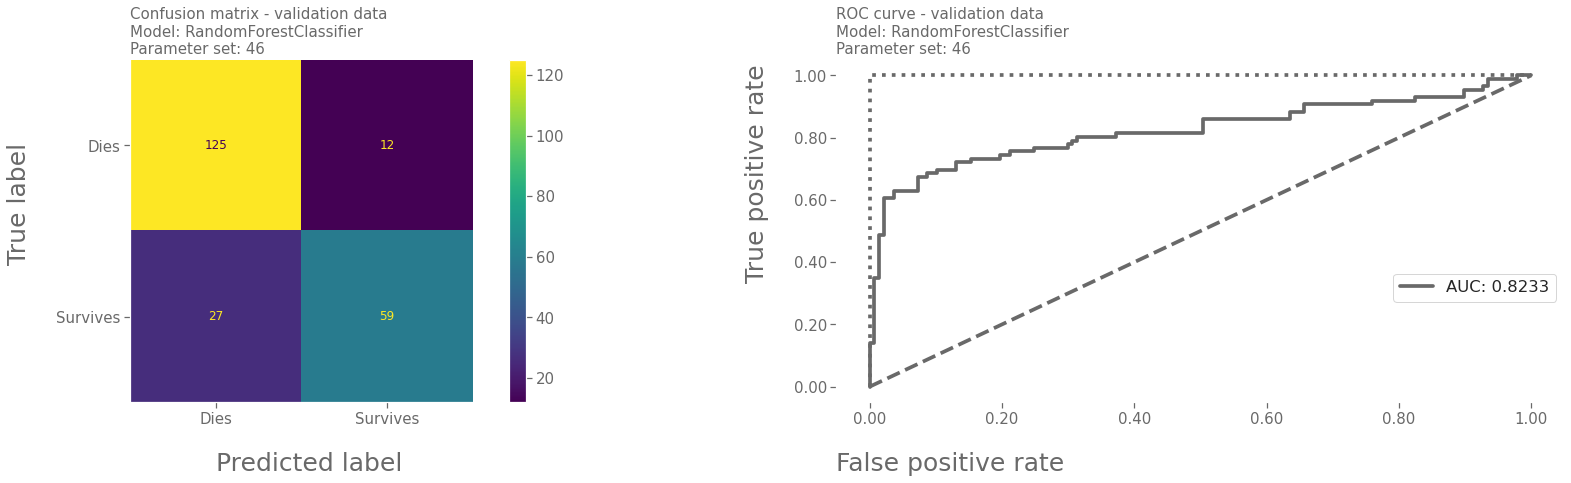

In [11]:
# classification panel, with validation data
X_train, X_valid, y_train, y_valid =\
    train_test_split(mlmachine_titanic_machine.training_features, mlmachine_titanic_machine.training_target)

mlmachine_titanic_machine.binary_classification_panel(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
    labels=["Dies", "Survives"],
)

*******************************************************
* Estimator: RandomForestClassifier
* Parameter set: 46
*******************************************************

*******************************************************
Training data evaluation

              precision    recall  f1-score   support

        Dies       0.93      0.98      0.95       549
    Survives       0.96      0.89      0.92       342

    accuracy                           0.94       891
   macro avg       0.95      0.93      0.94       891
weighted avg       0.94      0.94      0.94       891



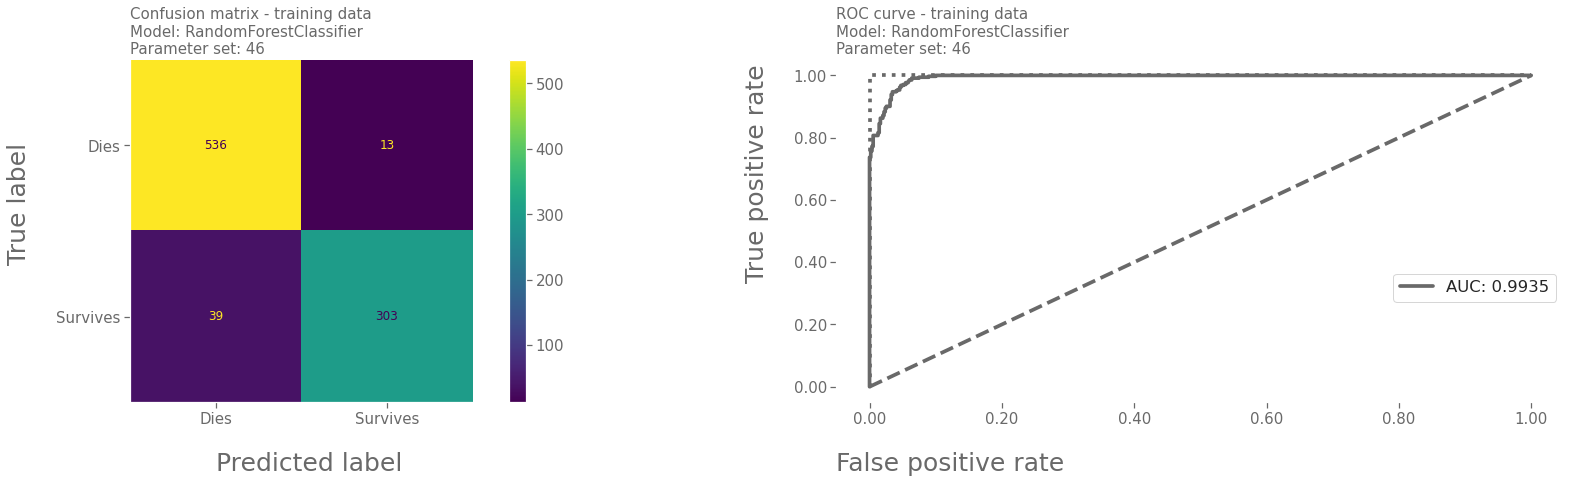


*******************************************************
Cross validation evaluation


*******************************************************
CV Fold 1

              precision    recall  f1-score   support

        Dies       0.81      0.92      0.86       183
    Survives       0.83      0.65      0.73       114

    accuracy                           0.81       297
   macro avg       0.82      0.78      0.79       297
weighted avg       0.82      0.81      0.81       297



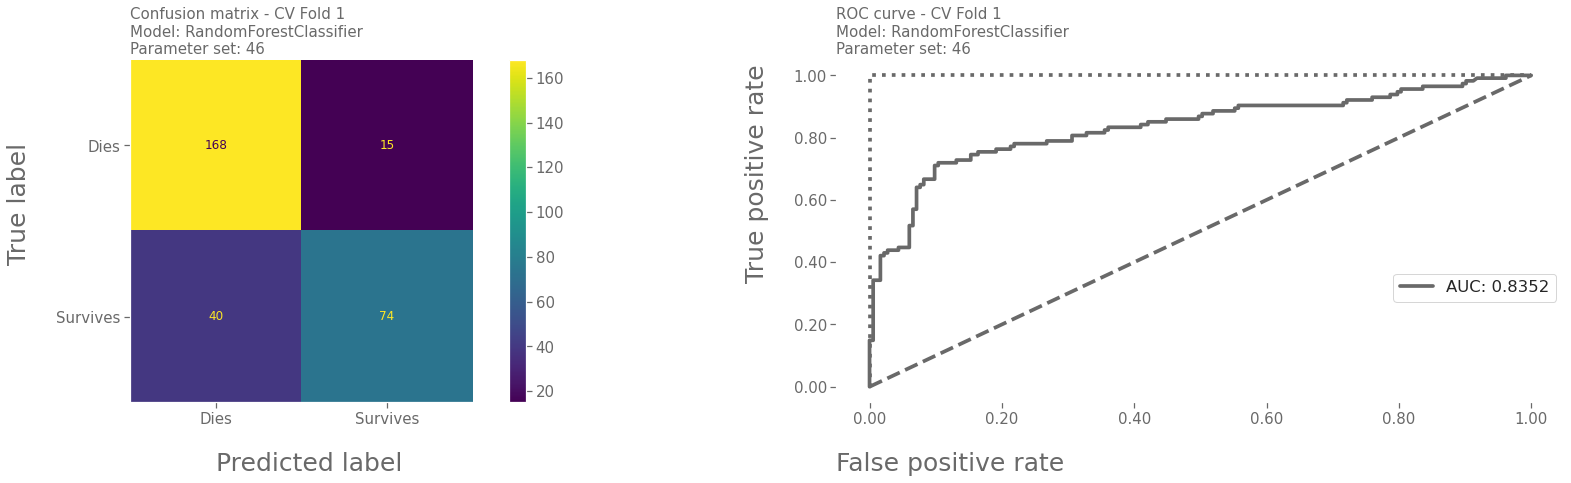


*******************************************************
CV Fold 2

              precision    recall  f1-score   support

        Dies       0.81      0.87      0.84       183
    Survives       0.77      0.67      0.71       114

    accuracy                           0.79       297
   macro avg       0.79      0.77      0.78       297
weighted avg       0.79      0.79      0.79       297



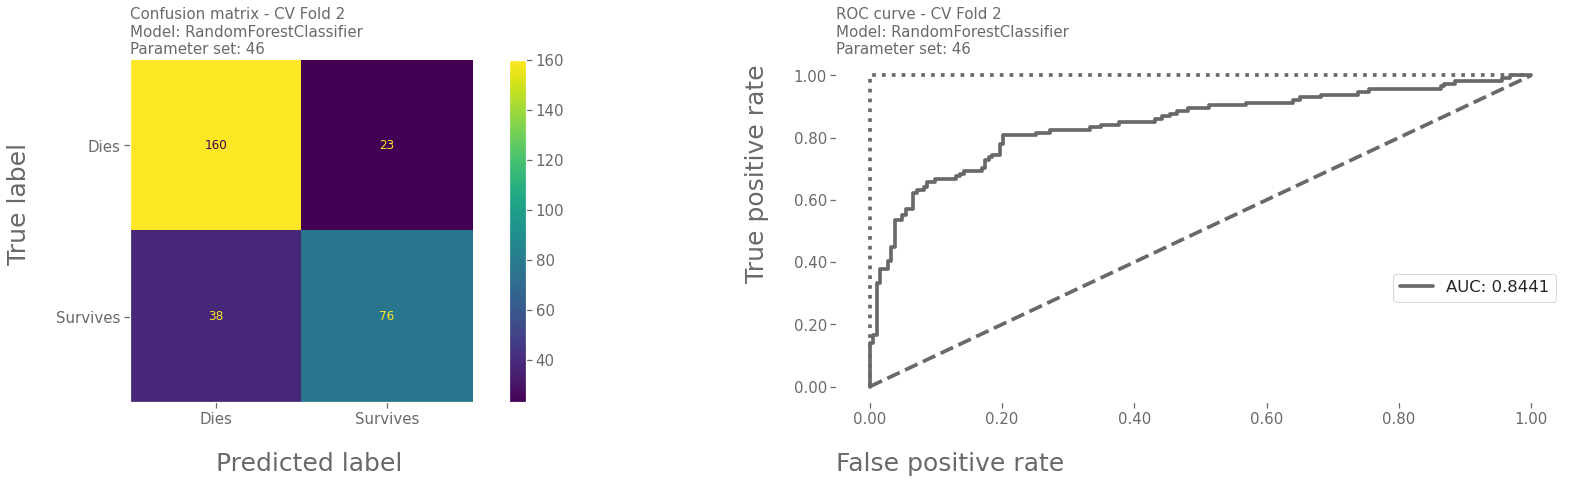


*******************************************************
CV Fold 3

              precision    recall  f1-score   support

        Dies       0.85      0.89      0.87       183
    Survives       0.81      0.75      0.78       114

    accuracy                           0.84       297
   macro avg       0.83      0.82      0.83       297
weighted avg       0.84      0.84      0.84       297



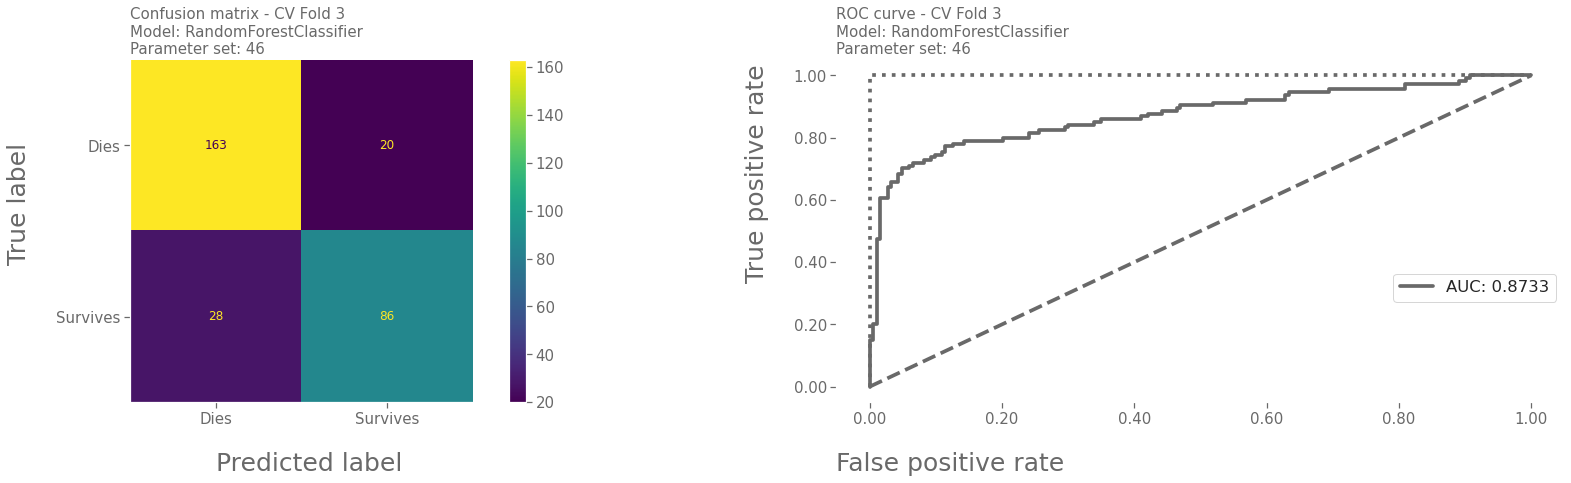

In [12]:
# create binary classification panel
mlmachine_titanic_machine.binary_classification_panel(
    model=model,
    X_train=mlmachine_titanic_machine.training_features,
    y_train=mlmachine_titanic_machine.training_target,
    labels=["Dies", "Survives"],
    n_folds=3
)